In [1]:
%config IPCompleter.greedy=True

In [2]:
import itertools, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as scp

# Analiza blockchain

Celem listy jest analiza systemu blockchain, a konkretniej - ataku **podwójnego wydatkowania** (ang. _double spending attack_). Zostaną tutaj przedstawione:
* analiza formuł zaproponowanych w pracach Nakamato i Grunspana dotyczących omawianego ataku,
* symulacja ataku _double spending_,
* porównanie wyników symulacji z wynikami teoretycznymi zawartymi we wspomnianych pracach.

## Wstępne założenia i oznaczenia

Niech $q \in (0, \frac{1}{2})$ oznacza prawdopodobieństwo wydobycia kolejnego bloku przez adwersarza, które odpowiada części mocy obliczeniowej przez niego posiadanej. Niech $n$ oznacza liczbę powtórzeń (nadbudowanych bloków) potrzebnych, by uznać transakcję za potwierdzoną. Niech $\Pr(n, q)$ oznacza prawbinomdopodobieństwo, że adwersarz o mocy obliczeniowej $q$ będzie dysponował łańcuchem bloków równym lub dłuższym niż ten budowany przez uczciwych użytkowników w momencie, gdy nabudowali oni blok zawierający rozważaną transakcję $n$ blokami lub kiedykolwiek później.

## Porównanie analizy Nakamato i Grunspana

Na początku zdefiniujmy sobie zdarzenie $E_n$ jako zrównanie się najdłuższej gałęzi łańcucha i gałęzi budowanej przez adwersarza w sytuacji, kiedy adersarzowi brakuje do zrównania się $n$ bloków. Niech $\Pr(E_n) = q_n$ oznacza prawdopodbieństwo wystąpienia takiego zdarzenia. Wówczas, na mocy **lematu 3.** możemy wyrazić to jako:

$\Pr[E_n] = q_n = (\frac{q}{p})^n$,

gdzie $q$ oznacza moc obliczeniową, którą dysponuje atakujący, a $p$ - moc należącąbinom do uczciwych użytkowników. Oczywiście $p = 1 - q$.

In [3]:
def q_n(n, q):
    p = 1 - q
    return (q/p)**n

### Analiza Nakamato

Niech $\Pr(n)$ oznacza prawdopodobieństwo, że adwersarzowi uda się zrównać budowany przez niego łańcuch z łańcuchem tworzonym przez uczciwych użytkowników w momencie, gdy nadbuowali oni łańcuch co najmniej $n$ blokami. Wartość $\Pr(n)$ można przedstawić jako:

$\Pr(n) = \Pr[N'(S_n) > n] + \sum_{k = 0}^n \Pr[N'(S_n) = k] \cdot q_{n - k}$

Nakamato w swojej pracy proponuje przyjęcie przybliżenia $N'(S_n)$ przez $N'(\mathbb{E}[S_n])$, gdzie  $\mathbb{E}[S_n] = n\mathbb{E}[T] = n\frac{\tau}{p}$, gdzie $\tau$ to średni czas wydobycia jednego bloku (w sieci `Bitcoin` wynosi on około 10 minut), a $T$ jest zmienną losową opisującą atak. Wówczas, wykonując odpowiednie przekształcenia, Nakamoto proponuje przyjęcie przybliżenia:

$\Pr(n) \approx 1 - \sum{k = 1}^{n - 1} e^{-\lambda}\frac{\lambda^{k}}{k!}(1 - q_{n-k})$

W związku z tym, że analiza ta przyjmuje założenie $N'(S_n) \approx N'(\mathbb{E}[S_n])$, nie jest ona zbyt prezycyjna. 

### Analiza Grunspan'a

Grunspan w swojej pracy przedstawił dokładniejszą analizę sieci `Bitcoin` niż Nakamato. Zawarł on w niej następujące twierdzenie:

**Twierdzenie 1**
Niech $X_n$ będzie zmienną losową oznaczającą liczbę bloków wydobytych przez adwersarza w chwili, gdy uczciwi użytkownicy nadbudowali rozważany blok $n$ blokami. Wówczas zmienna $X_n$ ma rozkład ujemny duwmianowy z parametrami $n$ oraz $p$:

$\Pr[X_n = k] = p^nq^k \binom{k +n - 1}{k}$

Wykorzystując to twierdzenie możemy przedstawić zdefiniowane wcześniej $\Pr(n)$ (prawdopodobieństwo, że adwersarz zbuduje łańcuch równy lub dłuższy od tego budowanego przez uczciwych użytkowników, gdy nabudowali oni blok co najmniej $n$ nowymi blokami) jako:

$\Pr(n) = 1 - \sum_{k = 0}^{n - 1}(p^nq^k - q^np^k)\binom{k + n - 1}{k}$

Łatwo zauważyć, że mamy tutaj do czynienia z dokładną wartością, a nie tylko z oszacowaniem jak w przypadku analizy przedstawione przez Nakamoto.

### Porównanie wyników (a)

Zgodnie z poleceniem listy należało porównać wyniki uzyskane przy pomocy obu analiz dla $\Pr(n, q)$ dla $n = 1, 3, 6, 12, 24, 48$ i różnych wartości $q$, a następnie przedstawić wykres zależności $P(n, q)$ w zależności od parametru $q$.

In [4]:
# Values of param n
ns = [1, 3, 6, 12, 24, 48]

# Values of param q (not exactly defined on the list)
qs = [0.1, 0.15, 0.2, 0.25, 0.30]

In [5]:
# Probability from Nakamoto's analysis
def p_nakamoto(n, q):
    p = 1 - q
    l = n * (q / p) # lambda
    ps = 0
    for k in range(0, n):
        ps += math.exp(-l) * ((l**k) / math.factorial(k)) * (1 - q_n(n - k, q))
    return 1 - ps

In [6]:
# Probability from Grunspan's analysis
def p_grunspan(n, q):
    p = 1 - q
    ps = 0
    for k in range(0, n):
        ps += (math.pow(p, n) * math.pow(q, k) - math.pow(q,n) * math.pow(p, k)) * scp.comb(k + n - 1, k)
    return 1 - ps

In [7]:
def create_df_pns(ns, qs, p_func):
    return pd.DataFrame([[n, q, p_func(n, q)] for n, q in itertools.product(ns, qs)], columns=['n', 'q', 'P(n,q)'])

In [8]:
pns_nakamoto = create_df_pns(ns, qs, p_nakamoto)
pns_nakamoto

,n,q,"P(n,q)"
0,1,0.10,2.045873e-01
1,1,0.15,3.096983e-01
2,1,0.20,4.158994e-01
3,1,0.25,5.223125e-01
4,1,0.30,6.277491e-01
5,3,0.10,1.317224e-02
6,3,0.15,4.422781e-02
7,3,0.20,1.032416e-01
8,3,0.25,1.961153e-01
9,3,0.30,3.245841e-01


In [9]:
pns_grunspan = create_df_pns(ns, qs, p_grunspan)
pns_grunspan

,n,q,"P(n,q)"
0,1,0.10,2.000000e-01
1,1,0.15,3.000000e-01
2,1,0.20,4.000000e-01
3,1,0.25,5.000000e-01
4,1,0.30,6.000000e-01
5,3,0.10,1.712000e-02
6,3,0.15,5.322375e-02
7,3,0.20,1.158400e-01
8,3,0.25,2.070312e-01
9,3,0.30,3.261600e-01


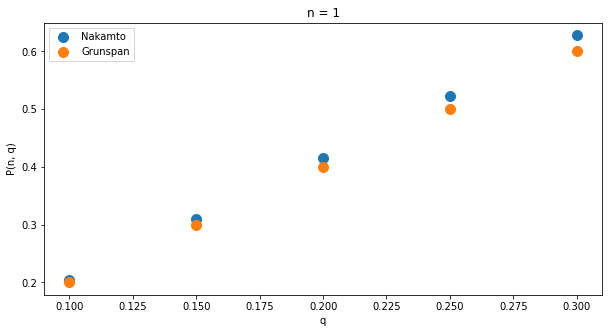

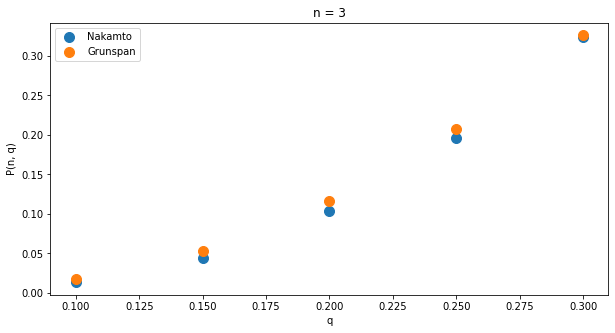

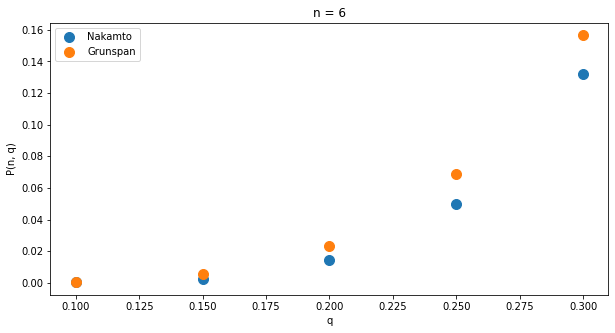

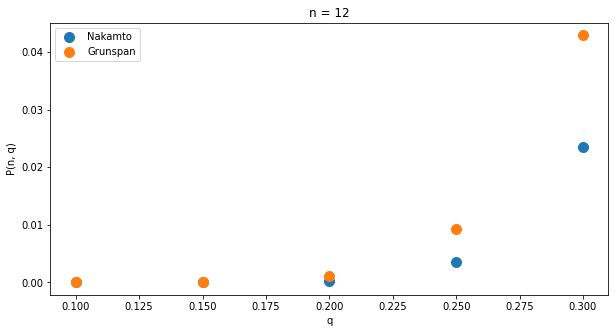

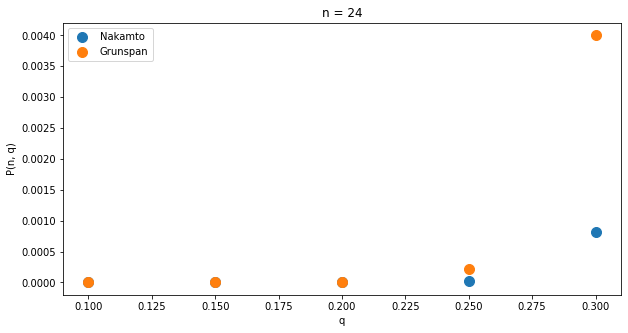

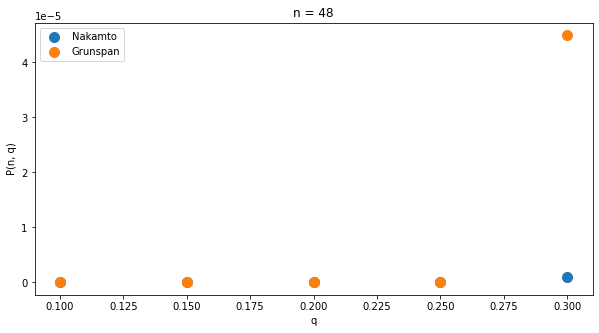

In [10]:
for n in ns:
    nakamoto_data = pns_nakamoto.loc[pns_nakamoto['n'] == n]
    grunspan_data = pns_grunspan.loc[pns_grunspan['n'] == n]
    size = 100
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(nakamoto_data['q'], nakamoto_data['P(n,q)'], s=size, label='Nakamto')
    ax.scatter(grunspan_data['q'], grunspan_data['P(n,q)'], s=size, label='Grunspan')
    ax.legend()
    ax.set_xlabel('q')
    ax.set_ylabel('P(n, q)')
    ax.set_title('n = {}'.format(n))

Teraz spróbujmy tak dobrać wartość $n$ (w zależności od parametru $q$), aby ustalić dopuszczalne prawdopodobieństwo sukcesu $\Pr(n, q) = 0.1\%, 1\%, 10\%$. Będziemy sprawdzać dla jakiej wartośći parametru $n$ wartość prawdopodobieństwa $\Pr(n,q)$ będzie większa bądź równa od zadanych wartości. Znajdziemy wtedy ograniczenie, czyli wspomniane na początku dopuszczalne prawdopodobieństwo sukcsu, a dokładniej - jego dopuszczalną wartość.

In [11]:
# Probability bounds
pnqs = [0.001, 0.01, 0.1]

# q parameter values
qs = [0.01 * i for i in range(1, 40)]

In [12]:
def best_fit(q, p_func, pnq_limit):
    n = 1
    while p_func(n, q) >= pnq_limit:
        n += 1
    return n

In [13]:
def create_df_best_n(qs, pnqs, p_func):
    return pd.DataFrame([[q, best_fit(q, p_func, pnq), pnq] for q, pnq in itertools.product(qs, pnqs)], columns=['q', 'n', 'P(n,q)'])

In [14]:
best_n_nakamoto = create_df_best_n(qs, pnqs, p_nakamoto)
best_n_nakamoto

,q,n,"P(n,q)"
0,0.01,2,0.001
1,0.01,2,0.010
2,0.01,1,0.100
3,0.02,3,0.001
4,0.02,2,0.010
...,...,...,...
112,0.38,41,0.010
113,0.38,19,0.100
114,0.39,74,0.001
115,0.39,48,0.010


In [15]:
best_n_grunspan = create_df_best_n(qs, pnqs, p_grunspan)
best_n_grunspan

,q,n,"P(n,q)"
0,0.01,2,0.001
1,0.01,2,0.010
2,0.01,1,0.100
3,0.02,3,0.001
4,0.02,2,0.010
...,...,...,...
112,0.38,57,0.010
113,0.38,24,0.100
114,0.39,110,0.001
115,0.39,68,0.010


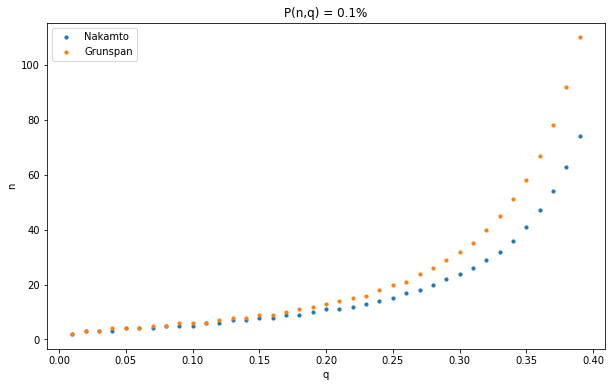

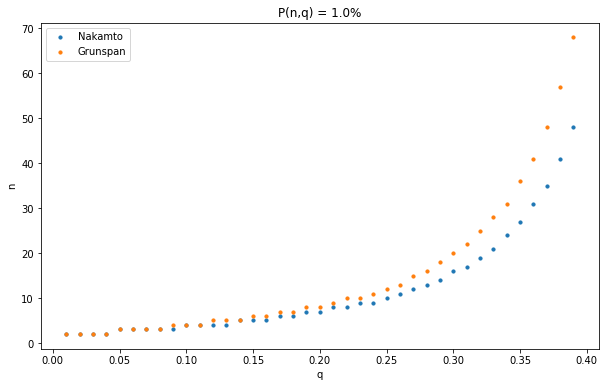

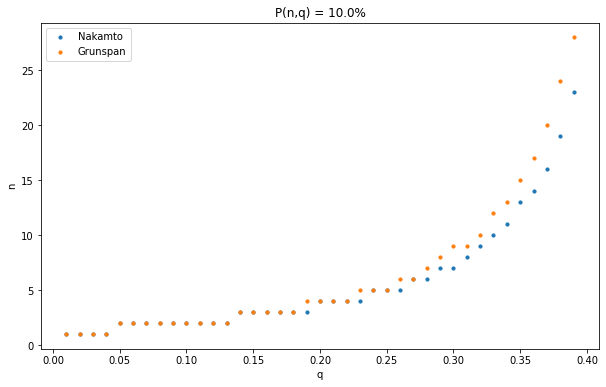

In [16]:
for pnq in pnqs:
    nakamoto_data = best_n_nakamoto.loc[best_n_nakamoto['P(n,q)'] == pnq]
    grunspan_data = best_n_grunspan.loc[best_n_grunspan['P(n,q)'] == pnq]
    size=10
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(nakamoto_data['q'], nakamoto_data['n'], s=size, label='Nakamto')
    ax.scatter(grunspan_data['q'], grunspan_data['n'], s=size, label='Grunspan')
    ax.legend()
    ax.set_xlabel('q')
    ax.set_ylabel('n')
    ax.set_title('P(n,q) = {}%'.format(pnq * 100))

## Double spending attack

Kolejnym krokiem jest przeprowadzenie symulacji **ataku podwójnego wydatkowania** (ang. _double spending attack_). Zakładając, że wiemy w jaki sposób działa technologia `blockchain`, wtedy taki atak przedstawia się następująco:
1. Adwersarz wysyła do systemu deklarację wykonania transakcji $t$ (przekazanie monet sprzedającemu). Blok $B$ zawierający transakcję $t$ zostaje dołączony do nabliżeszj gałęzi.
2. Adwersarz równolegle (niejawnie) buduje alternatywną gałąź, która bazuje na ostatnim bloku przed dołączeniem bloku $B$. W swojej gałęzy umieszcza transakcję $t'$, w której przekazuje monety użytkownikowi innemu niż sprzedający.
3. Adwersarz czeka do momentu, aż transakcja $t$ otrzyma w _uczciwej_ gałęzi odpowiednią liczbę potwierdzeń (nadbudowanych bloków nad dodanym blokiem $B$), a sprzedający np. wyśle przedmiot transakcji, np. jakiś produkt.
4. Adwersarz kontynuuje rozbudowę swojej gałęzi do momentu, aż będzie ona dłuższa od gałęzi _uczciwej_. W momencie, gdy osiągnie żądaną długość, publikuje swoją gałąź. Ponieważ jest ona wtedy najdłuższa to pozostali (uczciwi) użytkownicy systemu uznają ją za gałąź obowiązującą. Transakcja $t$ (_uczciwa_) zostaje w powszechnym mnienamniu zastąpiona za pomocą _nieuczciwej_ transakcji $t'$.

Do dokonania takiego ataku jest potrzebna, oczywiście, odpowiednia moc obliczeniowa. Moc adwersarza musi być zatem większa od mocy, którą dysponują uczciwi użytkownicy po to, aby w takim samym czasie był w stanie nadbudować taką samą liczbę bloków jak pozostali użytkownicy sieci. Aby utrudnić wykonanie takiego ataku, zastosowano pewne techniki. Do potwierdzenia transakcji każdy użytkownik musi np. wygenerować pewną, określoną liczbę haszy. Jest to koncpecja dowodu zwanego **dowodem wykonania pracy** (ang. _proof-of-work_).

### Implementacja

Zakładamy, że przeprowadzamy atak tak, jak to opisano w poprzedniej części. Skupmy się teraz na tym, w jaki sposób generowany jest pojedynczy blok:
1. Wylosuj wartość $\mathrm{nonce} \in [0, 2^{32} - 1]$.
2. Skonkatenuj $\mathrm{nonce}$ z haszem poprzedniego bloku $h_{\mathrm{prev}}$ i listą transakcji do umieszczenia w nowym (aktualnym) bloku: $h = H(\mathrm{nonce} || h_{\mathrm{prev}} || t_1 || t_2 || \ldots)$.
3. Sprawdź czy hasz $h$ traktowany jako liczba rzeczywista z przedziału $[0, 1)$ jest mniejszy od pewnego ustalonego parametru $\delta$ (ma odpowiednio dużą liczbę zer znaczących). Jeżeli tak - udało się wygenerować nowy blok. W przeciwnym przypadku należy powtórzyć całą procedurę. 

Łatwo zauważyć, że wartość $\delta$ definiuje to, jak trudne jest wygenerowanie bloku. Im _węższy_ przedział $[0, \delta)$, tym trudniejsze jest wygenerowanie bloku, ponieważ zakres dopuszczalnych wartości jest mniejszy. W przypadku technologii `Blockchain` istotnym jest, aby parametr $\delta$ miał przełożenie na moc obliczeniową, czyli na czas potrzebny do tego, aby wygenerować nowy blok. Przyjmijmy, że ten czas jest opisywany przez parameter $\lambda$. W sieci `Blockchain` wynosi on około **10 minut**.

Możemy zauważyć, że ten proces możemy opisać za pomocą błądzenia po prostej. Jeżeli uda się wygenerować hasz $h < \delta$ to wówczas przesuwamy się o jedną jednostkę w prawo, czyli w tym przypadku - dobudowujemy nowy blok do gałęzi. 

In [24]:
def simulate_attack(n, q):
    treshold = 30
    legitimate_branch = 0
    adversary_branch = 0
    
    while True:
        if random.random() <= q:
            adversary_branch += 1
        else:
            legitimate_branch += 1
            
        if legitimate_branch < n:
            continue
    
        if adversary_branch >= legitimate_branch:
            return True
        elif legitimate_branch >= n + treshold:
            return False

Powyższy kod opiera się na dwóch parametrach: $q$, który opisuje moc obliczeniową należącą do adwersarza, oraz $n$, który wyraża wymaganą długość gałęzi (liczbę dobudowanych bloków). Wcześniej stwierdziliśmy, że parametr $\delta$ ma wpływ na czas generowania nowego bloku $\lambda$, a ten z kolei zależy jest od mocy obliczeniowej adwersarza $q$. Możemy przyjąć, że $\lambda \sim q$. Na początku zdefiniowaliśmy również, że $q \in [0, \frac{1}{2})$ dostępnej mocy obliczeniowej wszystkich użytkowników. Przyjmując, że $p$ wyraża moc obliczeniową uczciwych użytkowników, to wówczas widzmy, że $q < p$ - adwersarz dysponuje mniej niż połową dostępnej mocy obliczeniowej. Oczywiście $p + q = 1$.

Przeprowadźmy teraz symulację wykorzystując metodę **Monte Carlo**, która polega na wielokrotnym powtarzaniu danego eksperymentu.

In [25]:
# Number of trials
trials = 10000

# Values of adversary's computing power
qs = [0.01 * i for i in range(50)]

# Possible lengths of branch to confirm transaction
ns = [1, 3, 6, 12, 24, 48]

In [26]:
def p_dsa(n, q, trials=trials):
    successful_attacks = 0

    for _ in range(trials):
        if simulate_attack(n, q):
            successful_attacks += 1

    return successful_attacks/trials

In [27]:
pns_nakamoto = create_df_pns(ns, qs, p_nakamoto)
pns_grunspan = create_df_pns(ns, qs, p_grunspan)
pns_dsa = create_df_pns(ns, qs, p_dsa)

In [28]:
pns_dsa

,n,q,"P(n,q)"
0,1,0.00,0.0000
1,1,0.01,0.0192
2,1,0.02,0.0408
3,1,0.03,0.0606
4,1,0.04,0.0771
...,...,...,...
295,48,0.45,0.2803
296,48,0.46,0.3667
297,48,0.47,0.4519
298,48,0.48,0.5447


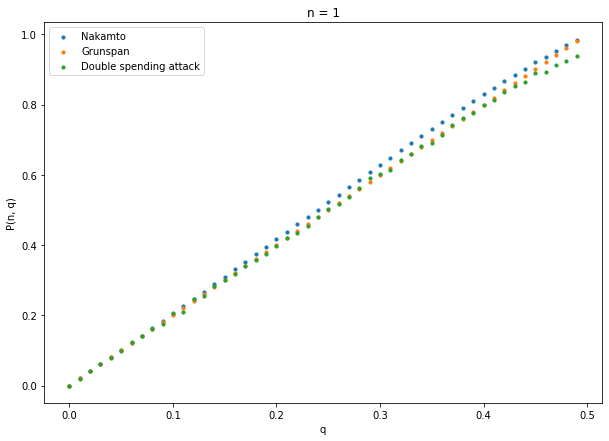

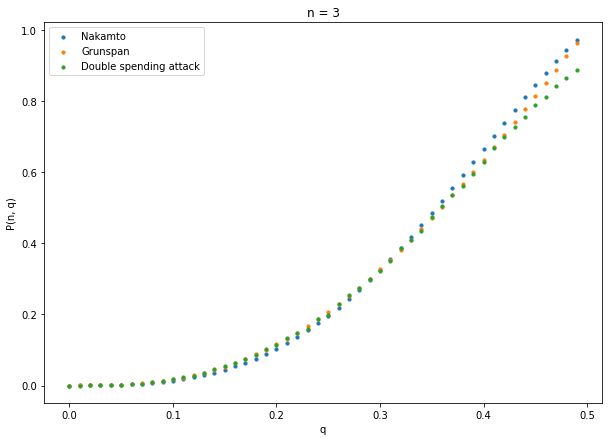

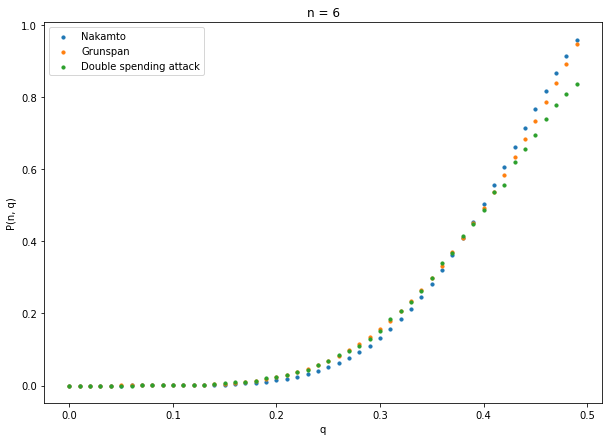

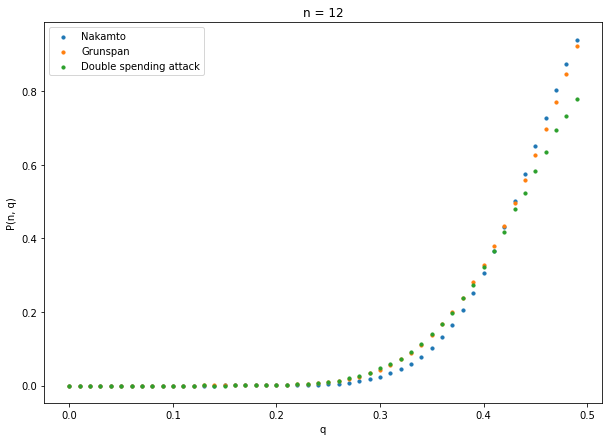

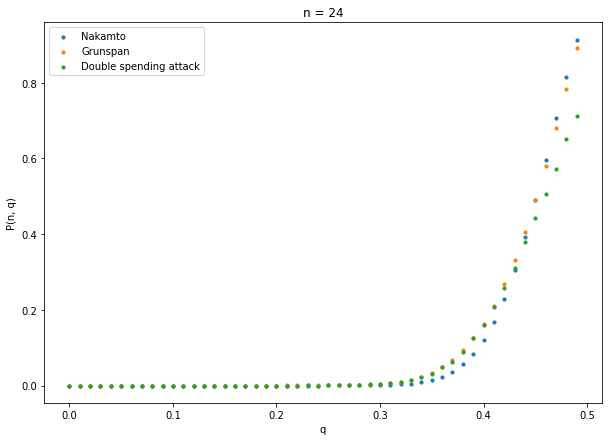

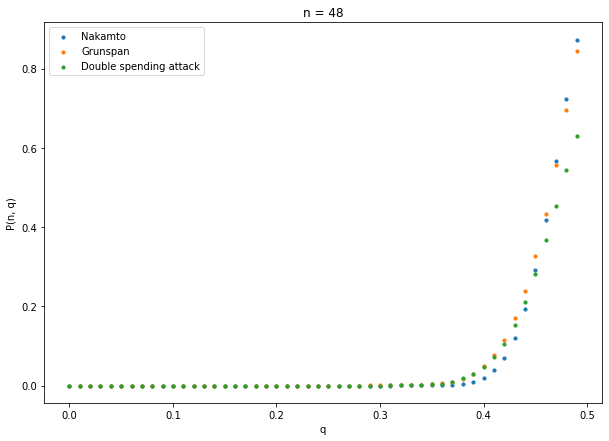

In [29]:
for n in ns:
    nakamoto_data = pns_nakamoto.loc[pns_nakamoto['n'] == n]
    grunspan_data = pns_grunspan.loc[pns_grunspan['n'] == n]
    dsa_data = pns_dsa.loc[pns_dsa['n'] == n]
    size = 10
    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.scatter(nakamoto_data['q'], nakamoto_data['P(n,q)'], s=size, label='Nakamto')
    ax.scatter(grunspan_data['q'], grunspan_data['P(n,q)'], s=size, label='Grunspan')
    ax.scatter(dsa_data['q'], dsa_data['P(n,q)'], s=size, label='Double spending attack')
    ax.legend()
    ax.set_xlabel('q')
    ax.set_ylabel('P(n, q)')
    ax.set_title('n = {}'.format(n))

### Wnioski

Zauważamy pewną rozbieżność pomiędzy wynikami zwracanymi przez metody przedstawione przez Nakamato i Grunspana a symulacją ataku. Wynika to z tego, że eksperyment był oparty o metodę _Monte Carlo_. Użycie generator liczb pseudolodowych uniemożliwia nam otrzymanie dokładnych wyników tak jak w przypadku metod analitycznych. Intuicyjnie mogłoby się wydawać, że może to zależeć od rodzaju generatora użytego w eksperymencie (tutaj został uzyty generator ze standardowej biblioteki języka `Python`). Jednak dowiedziono, że nie w przypadku metody _Monte Carlo_ otrzymywane wyniki nie zależą od rodzaju generatora. Podobne rezultaty otrzymalibyśmy dla generatora, który generuje liczby zbliżone do _prawdziwie losowych_.